In [16]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

In [27]:
def convert_data(folder_name:str, data:pd.DataFrame, mean_size:int):
    """
    Takes on input dataframe with filenames and parameters for picture recizing.
    Returns faces dataframe in the form of an array and label dataframe.
    """
    
    def img_to_array(name: str, xmin: int,ymin: int,xmax: int,ymax: int) -> np.array:
        """
        Takes dataframes columns, opens image and cuts faces from there (with resizing)
        """
        img = Image.open(f'.\\{folder_name}\\{name}').crop((xmin,ymin,xmax,ymax)).resize((mean_size, mean_size))
        return((np.asarray(img)/255.0))  
    new_data = data.copy()

    new_data['img_as_array'] = new_data.apply(lambda x: img_to_array(x.filename, x.xmin, x.ymin, x.xmax, x.ymax), axis=1)
    
    train_images = np.array(new_data['img_as_array'].values.tolist())
    train_labels =new_data['class'].factorize()[0]
    
    return train_images, train_labels

In [28]:
train_data = pd.read_csv(r".\train\_annotations.csv")

In [29]:
# In order to understand what average values to take to equalize the sizes of all images
train_data['delta_x'] = train_data['xmax']-train_data['xmin']
train_data['delta_y'] = train_data['ymax']-train_data['ymin']
x_mean=round(train_data['delta_x'].mean())
y_mean=round(train_data['delta_y'].mean())
mean_size = (x_mean+y_mean)//2
print(f'Resize images to mean delta X: {x_mean} and mean delta Y: {y_mean}. Lets take as size {mean_size} for simplicity.')

Resize images to mean delta X: 40 and mean delta Y: 50. Lets take as size 45 for simplicity.


In [30]:
train_images, train_labels = convert_data('train', train_data, mean_size)

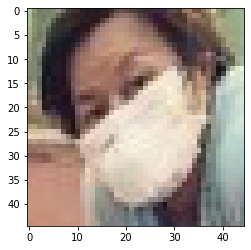

In [31]:
plt.imshow(train_images[0])

In [32]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(mean_size, mean_size, 3)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

In [33]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [55]:
valid_data = pd.read_csv(r".\valid\_annotations.csv")
valid_images, valid_labels = convert_data('valid', valid_data, mean_size)

In [56]:
model.fit(train_images, train_labels, epochs=5, validation_data=(valid_images, valid_labels))

Epoch 1/5
22/22 [==============================] - 2s 88ms/step - loss: 0.2959 - accuracy: 0.8233 - val_loss: 0.3263 - val_accuracy: 0.8827
Epoch 2/5
22/22 [==============================] - 1s 38ms/step - loss: 0.2814 - accuracy: 0.8319 - val_loss: 0.2679 - val_accuracy: 0.8951
Epoch 3/5
22/22 [==============================] - 2s 89ms/step - loss: 0.2690 - accuracy: 0.8420 - val_loss: 0.2565 - val_accuracy: 0.8827
Epoch 4/5
22/22 [==============================] - 1s 55ms/step - loss: 0.2543 - accuracy: 0.8563 - val_loss: 0.2480 - val_accuracy: 0.8827
Epoch 5/5
22/22 [==============================] - 1s 56ms/step - loss: 0.2501 - accuracy: 0.8534 - val_loss: 0.2553 - val_accuracy: 0.8889


In [35]:
test_data = pd.read_csv(r".\test\_annotations.csv")

In [36]:
test_images, test_labels = convert_data('test', test_data, mean_size)

In [57]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

3/3 [==============================] - 0s 12ms/step - loss: 0.2190 - accuracy: 0.9375
Test accuracy: 0.9375


In [58]:
predictions = model.predict(test_images)

3/3 [==============================] - 0s 11ms/step


In [52]:
class_names = ['mask', 'no mask']

In [53]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

        plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(2), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

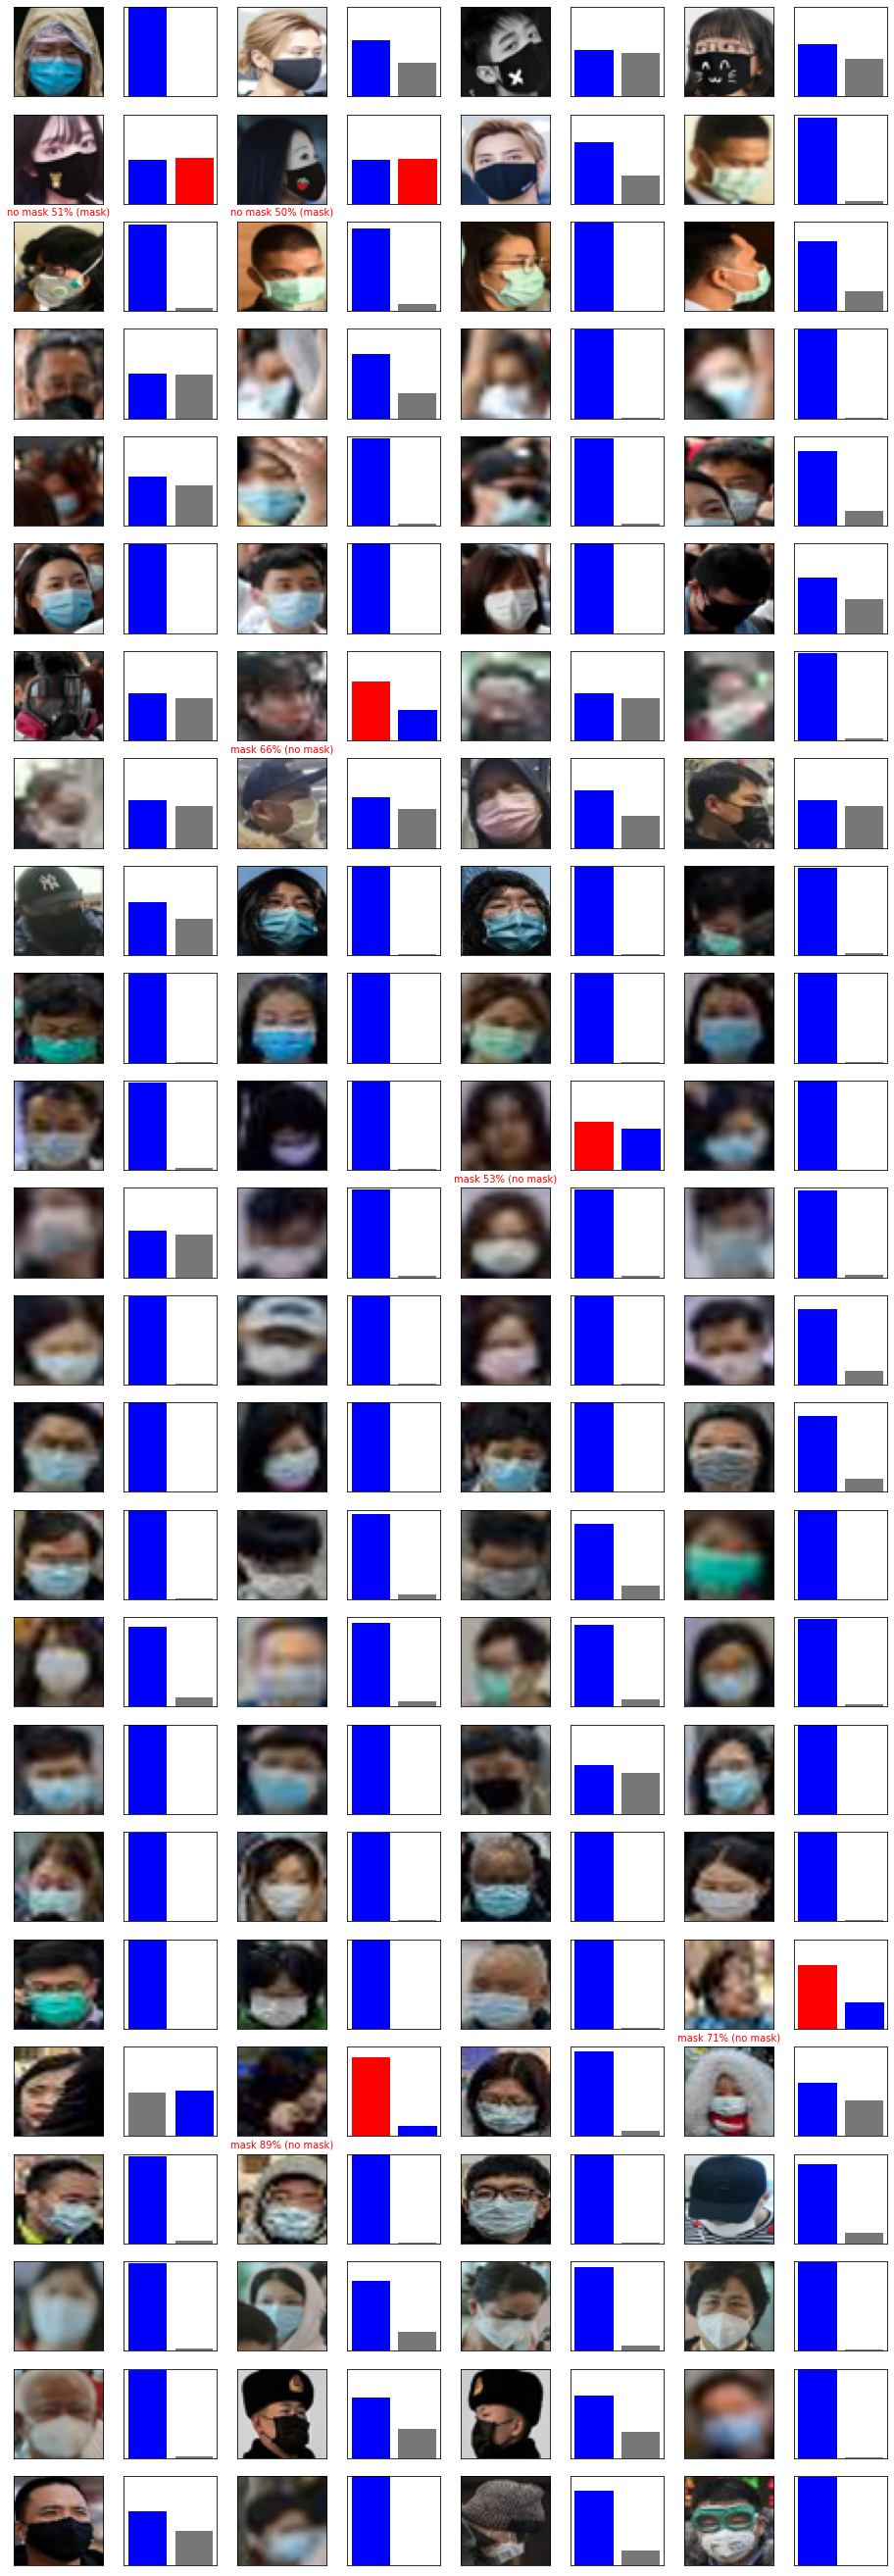

In [59]:
num_rows = 24
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels)

In [64]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(mean_size, mean_size, 3), padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [65]:
model2.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [66]:
model2.fit(train_images, train_labels, epochs=5, validation_data=(valid_images, valid_labels))

Epoch 1/5
22/22 [==============================] - 28s 1s/step - loss: 0.4524 - accuracy: 0.8233 - val_loss: 0.2637 - val_accuracy: 0.8765
Epoch 2/5
22/22 [==============================] - 26s 1s/step - loss: 0.2755 - accuracy: 0.8491 - val_loss: 0.2379 - val_accuracy: 0.8889
Epoch 3/5
22/22 [==============================] - 24s 1s/step - loss: 0.2241 - accuracy: 0.9052 - val_loss: 0.1552 - val_accuracy: 0.9259
Epoch 4/5
22/22 [==============================] - 23s 1s/step - loss: 0.2042 - accuracy: 0.9037 - val_loss: 0.1597 - val_accuracy: 0.9383
Epoch 5/5
22/22 [==============================] - 22s 984ms/step - loss: 0.1667 - accuracy: 0.9382 - val_loss: 0.1090 - val_accuracy: 0.9444


In [67]:
test_loss2, test_acc2 = model2.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc2)

3/3 [==============================] - 1s 287ms/step - loss: 0.1655 - accuracy: 0.9167
Test accuracy: 0.9166666865348816


In [68]:
predictions2 = model2.predict(test_images)

3/3 [==============================] - 2s 363ms/step


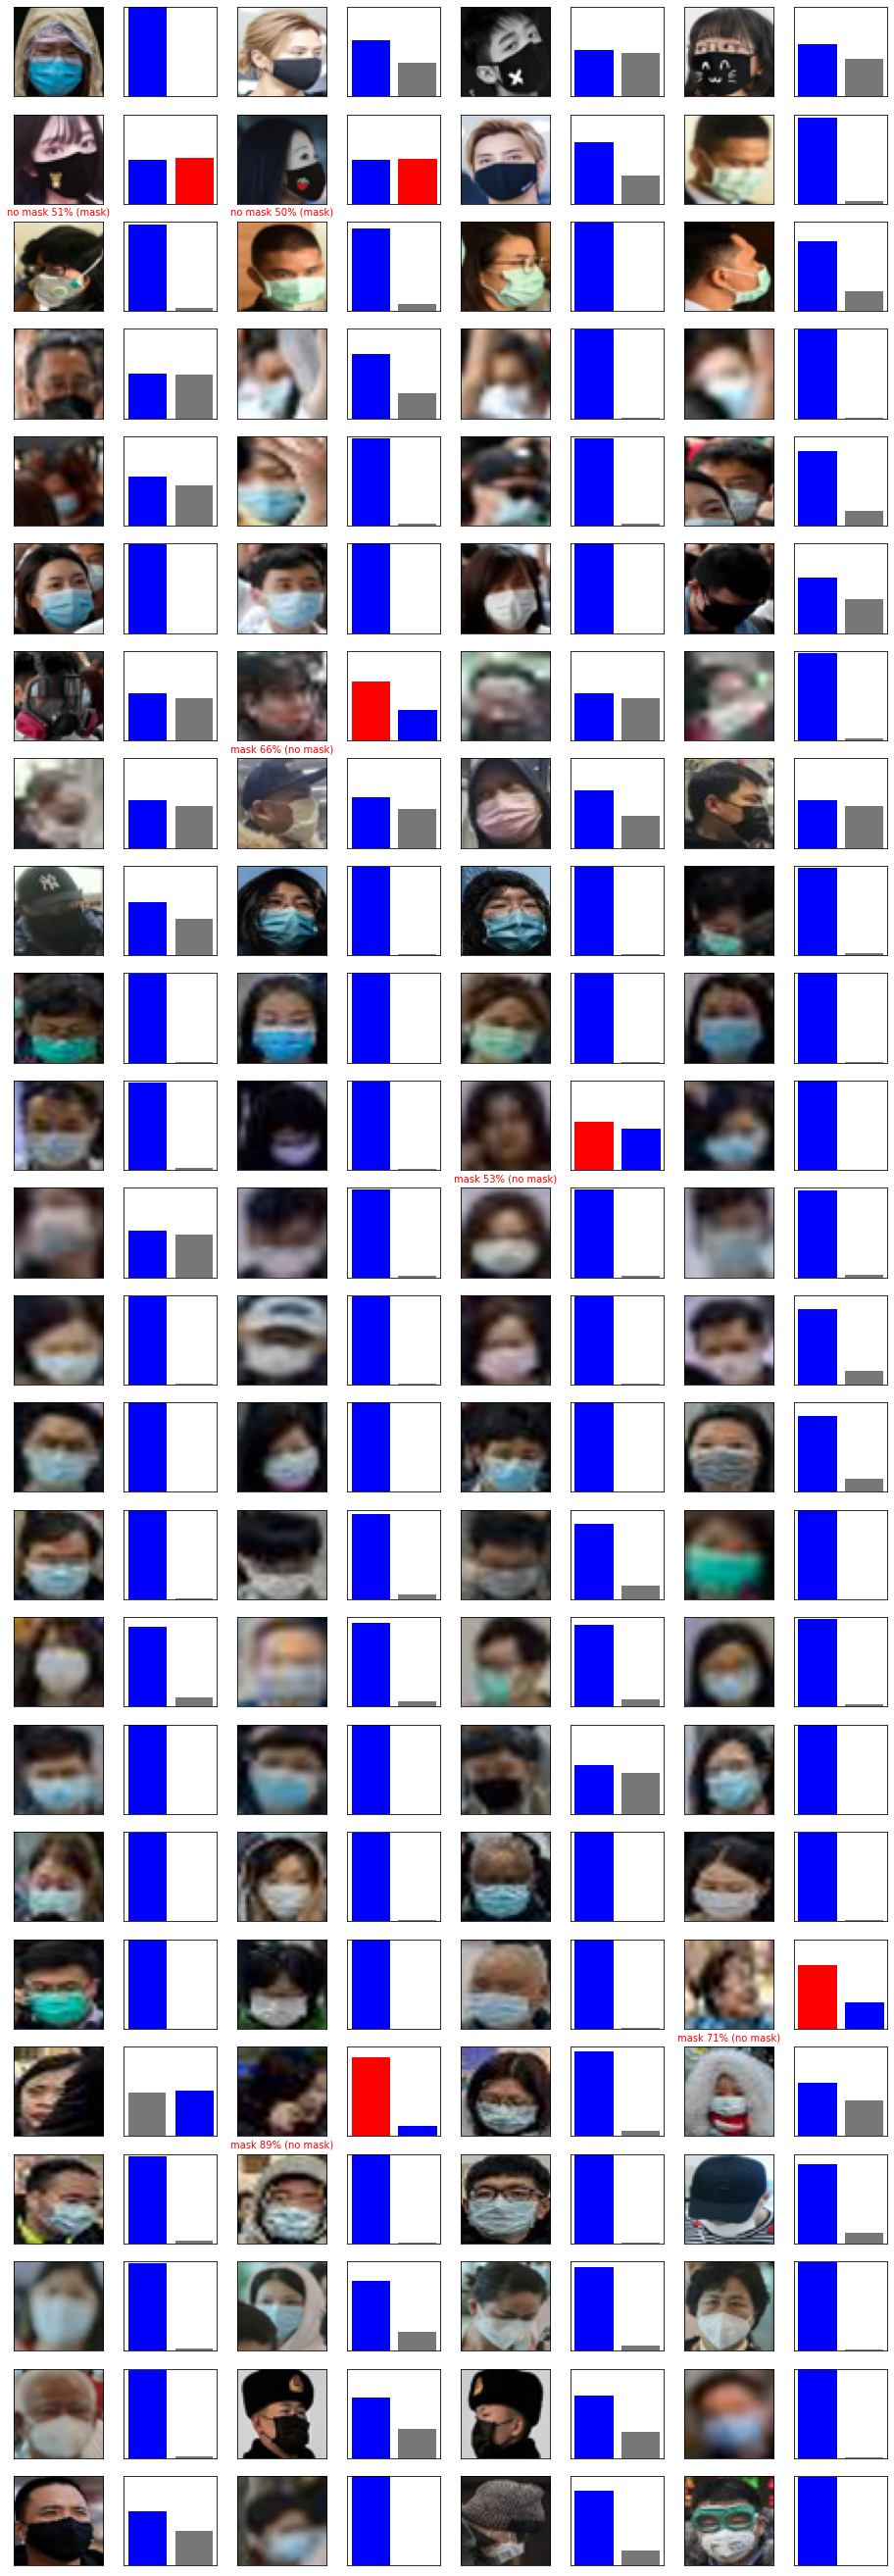

In [69]:
num_rows = 24
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels)